In [1]:
import datacube
from shapely import speedups

In [138]:
speedups.disable()

dc = datacube.Datacube(config="datacube.conf")
datasets = dc.index.datasets.search(lat=40)

for dataset in datasets:
    print(dataset)

# products = dc.index.products.get_all()
# data = dc.load(product=next(products))
# print(data)


ds = dc.load(product="ls8_level1_usgs", measurements=["panchromatic"],
             time=("2021-01-01", "2021-12-31"), output_crs='EPSG:4326', resolution=(-0.01, 0.01)
)
print(ds['panchromatic'])

D:\_PROJECTS\_SGM\sgm-opendatacube\venv\lib\site-packages\datacube\drivers\postgres\_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(


Dataset <id=efeb89ec-a87e-5c92-bee1-a563027e1659 product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=a6c25417-adf6-5dfd-b99f-a1a7d798e3b5 product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=edae552e-d180-5587-a3e0-90bb2e7aa724 product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=9c61cfae-43f8-506a-a350-b724018926ae product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=abf0b2c4-25ba-5c86-b9e9-1b12b1b7cfce product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=b1cb0b23-14d7-5e62-a951-2d4e2817de9a product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
Dataset <id=4e02df2b-643f-5145-83a9-0ad572ef3c6b product=ls8_level1_usgs location=file:///tmp/test-dataset.json>
<xarray.DataArray 'panchromatic' (time: 7, latitude: 501, longitude: 611)>
array([[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [    0,     

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [140]:
data = ds['panchromatic'].data

In [141]:
data.shape

(7, 501, 611)

In [142]:
composite = np.zeros(data.shape[1:], dtype=data.dtype)
for layer in data:
    composite = np.where( (layer >= 0) & (composite == 0), layer, composite)

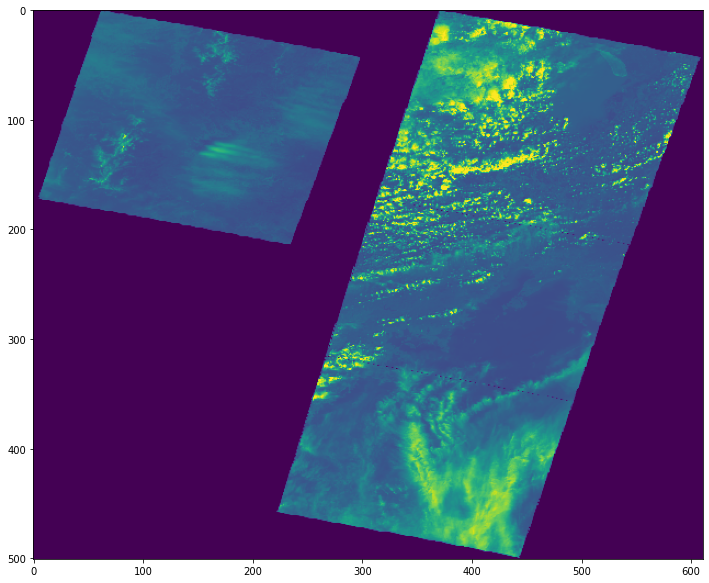

In [143]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(composite)


In [9]:
import rasterio
import random
from rasterio.windows import Window
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer

In [50]:

transformer = Transformer.from_crs(32652, 4326, always_xy=True)
transformer.transform(590392.5, 4667392.5)

(130.0940902997393, 42.153444839164464)

In [53]:
def transform_coords(points, crs1, crs2=4326):
    transformer = Transformer.from_crs(crs1, crs2, always_xy=True)
    result = [transformer.transform(x, y) for x, y in points]
    return result

In [57]:
def get_overview(url, factor=1):
    with rasterio.open(url, crs='EPSG:3857') as src:
        overviews = src.overviews(1)
        factor = factor if factor <= len(overviews) else len(overviews)
        scale = overviews[-factor]
        arr = src.read(1, out_shape=(src.height // scale, src.width // scale))        
        metadata = {'profile': src.profile, 'bounds': src.bounds}
        bounds = metadata['bounds']
        points = [
            (bounds.left, bounds.bottom),
            (bounds.left, bounds.top),
            (bounds.right, bounds.top),
            (bounds.right, bounds.bottom)
        ]
        points = transform_coords(points, metadata['profile']['crs'])
        metadata['points'] = points
    return arr, metadata

In [60]:
def save_png(arr, filename='temp.png'):
    img = Image.fromarray(arr)
    img.save(filename)

In [61]:
file = f'https://landsat-pds.s3.amazonaws.com/c1/L8/114/030/LC08_L1TP_114030_20210503_20210508_01_T1/LC08_L1TP_114030_20210503_20210508_01_T1_B8.TIF'
arr, metadata = get_overview(file, factor=2)
save_png(arr)

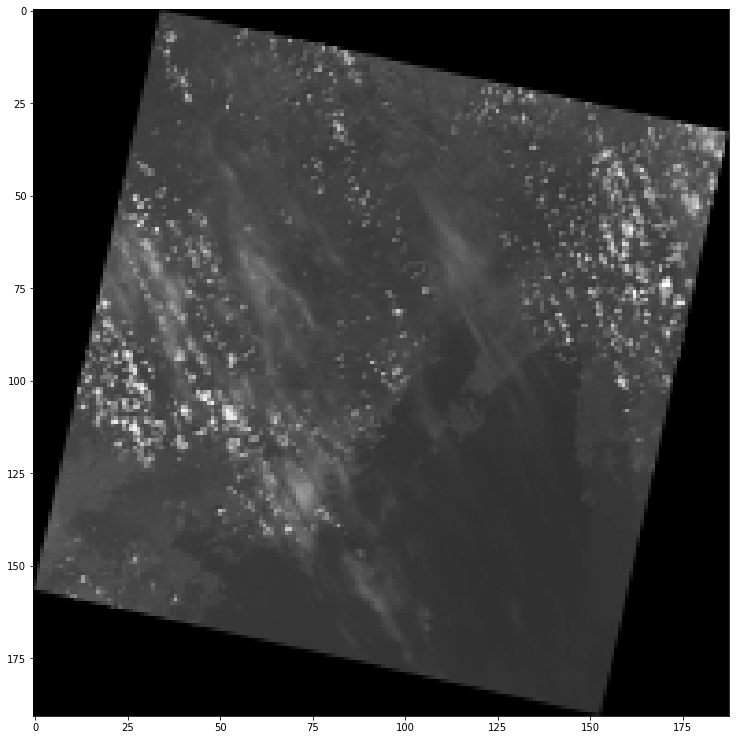

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(arr, cmap="gray")

In [3]:
with rasterio.Env(CPL_CURL_VERBOSE=True):
    with rasterio.open(f'https://landsat-pds.s3.amazonaws.com/c1/L8/114/030/LC08_L1TP_114030_20210503_20210508_01_T1/LC08_L1TP_114030_20210503_20210508_01_T1_B8.TIF') as src:
        print(src.height, src.width)
        windows = list(src.block_windows())
        print(len(windows))
        ij, window = random.choice(list(src.block_windows()))
        print(ij, window)
        #window = Window(2000, 2000, 10000, 10000)
        arr = src.read(window=window, out_shape=(512, 512))
        print(src.overviews(1))
        print(dir(src))

15521 15261
930
(29, 13) Window(col_off=6656, row_off=14848, width=512, height=512)
[3, 9, 27, 81]
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_size', 'block_window', 'bl

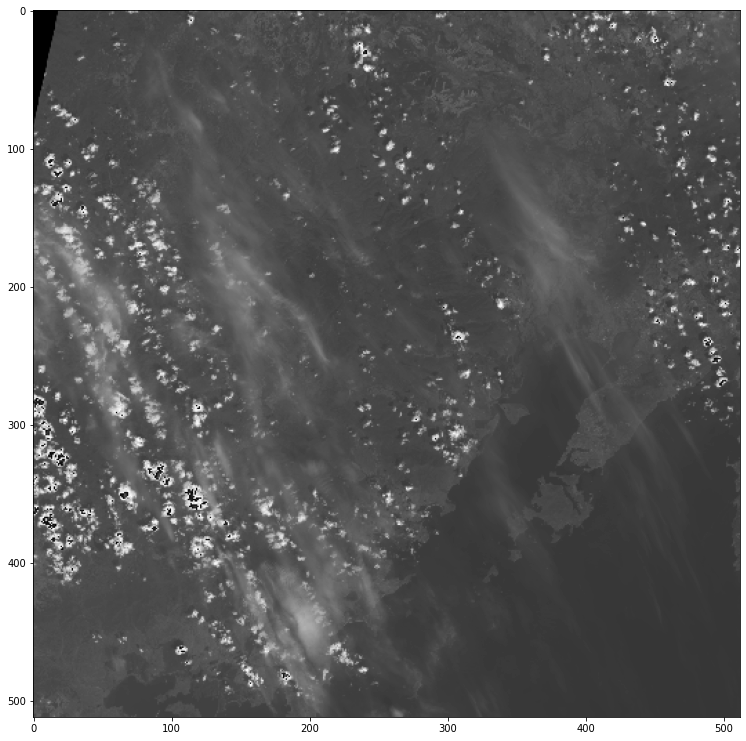

In [8]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(arr.squeeze() * 2, cmap="gray")